In [1]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from statsmodels.stats.diagnostic import normal_ad
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
import seaborn as sn
from sklearn.preprocessing import MinMaxScaler
import scipy.stats as stats
import pylab
import math

#### Importing the dataset

In [2]:
df = pd.read_excel('data.xlsx',sheetname="MH-Raw Data")
df.head(3)

,SL.,AGE,GENDER,MARITAL STATUS,KEY COMPLAINTS -CODE,BODY WEIGHT,BODY HEIGHT,HR PULSE,BP -HIGH,BP-LOW,...,CREATININE,MODE OF ARRIVAL,STATE AT THE TIME OF ARRIVAL,TYPE OF ADMSN,TOTAL COST TO HOSPITAL,TOTAL LENGTH OF STAY,LENGTH OF STAY - ICU,LENGTH OF STAY- WARD,IMPLANT USED (Y/N),COST OF IMPLANT
0,1,58.0,M,MARRIED,other- heart,49.2,160,118,100.0,80.0,...,0.8,AMBULANCE,ALERT,EMERGENCY,660293.0,25,12,13,Y,38000
1,2,59.0,M,MARRIED,CAD-DVD,41.0,155,78,70.0,50.0,...,1.7,AMBULANCE,ALERT,EMERGENCY,809130.0,41,20,21,Y,39690
2,3,82.0,M,MARRIED,CAD-TVD,46.6,164,100,110.0,80.0,...,0.8,WALKED IN,ALERT,ELECTIVE,362231.0,18,9,9,N,0


#### To start with, creating new dependent variable 'Total'

In [3]:
df['Total'] = df['TOTAL COST TO HOSPITAL '] + df['COST OF IMPLANT']
df.drop(['TOTAL COST TO HOSPITAL ', 'COST OF IMPLANT'], axis = 1, inplace = True )

#### Creating features for pre-processing

In [4]:
df.columns

Index(['SL.', 'AGE', 'GENDER', 'MARITAL STATUS', 'KEY COMPLAINTS -CODE',
       'BODY WEIGHT', 'BODY HEIGHT', 'HR PULSE', 'BP -HIGH', 'BP-LOW', 'RR',
       'PAST MEDICAL HISTORY CODE', 'HB', 'UREA', 'CREATININE',
       'MODE OF ARRIVAL', 'STATE AT THE TIME OF ARRIVAL', 'TYPE OF ADMSN',
       'TOTAL LENGTH OF STAY', 'LENGTH OF STAY - ICU', 'LENGTH OF STAY- WARD',
       'IMPLANT USED (Y/N)', 'Total'],
      dtype='object')

In [5]:
numerical_features = ['AGE','BODY WEIGHT','BODY HEIGHT','HR PULSE', 'BP -HIGH', 'BP-LOW', 'RR',
                      'HB', 'UREA', 'CREATININE', 'TOTAL LENGTH OF STAY',
                      'LENGTH OF STAY - ICU', 'LENGTH OF STAY- WARD', 'Total']

categorical_features = ['GENDER','MARITAL STATUS', 'MODE OF ARRIVAL',
                        'STATE AT THE TIME OF ARRIVAL', 'TYPE OF ADMSN', 'IMPLANT USED (Y/N)']

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248 entries, 0 to 247
Data columns (total 23 columns):
SL.                             248 non-null int64
AGE                             248 non-null float64
GENDER                          248 non-null object
MARITAL STATUS                  248 non-null object
KEY COMPLAINTS -CODE            212 non-null object
BODY WEIGHT                     248 non-null float64
BODY HEIGHT                     248 non-null int64
HR PULSE                        248 non-null int64
BP -HIGH                        225 non-null float64
BP-LOW                          225 non-null float64
RR                              248 non-null int64
PAST MEDICAL HISTORY CODE       75 non-null object
HB                              246 non-null float64
UREA                            235 non-null float64
CREATININE                      215 non-null float64
MODE OF ARRIVAL                 248 non-null object
STATE AT THE TIME OF ARRIVAL    248 non-null object
TYPE OF A

#### There exists null value. Analysing...

In [7]:
df.isnull().any().sum()

7

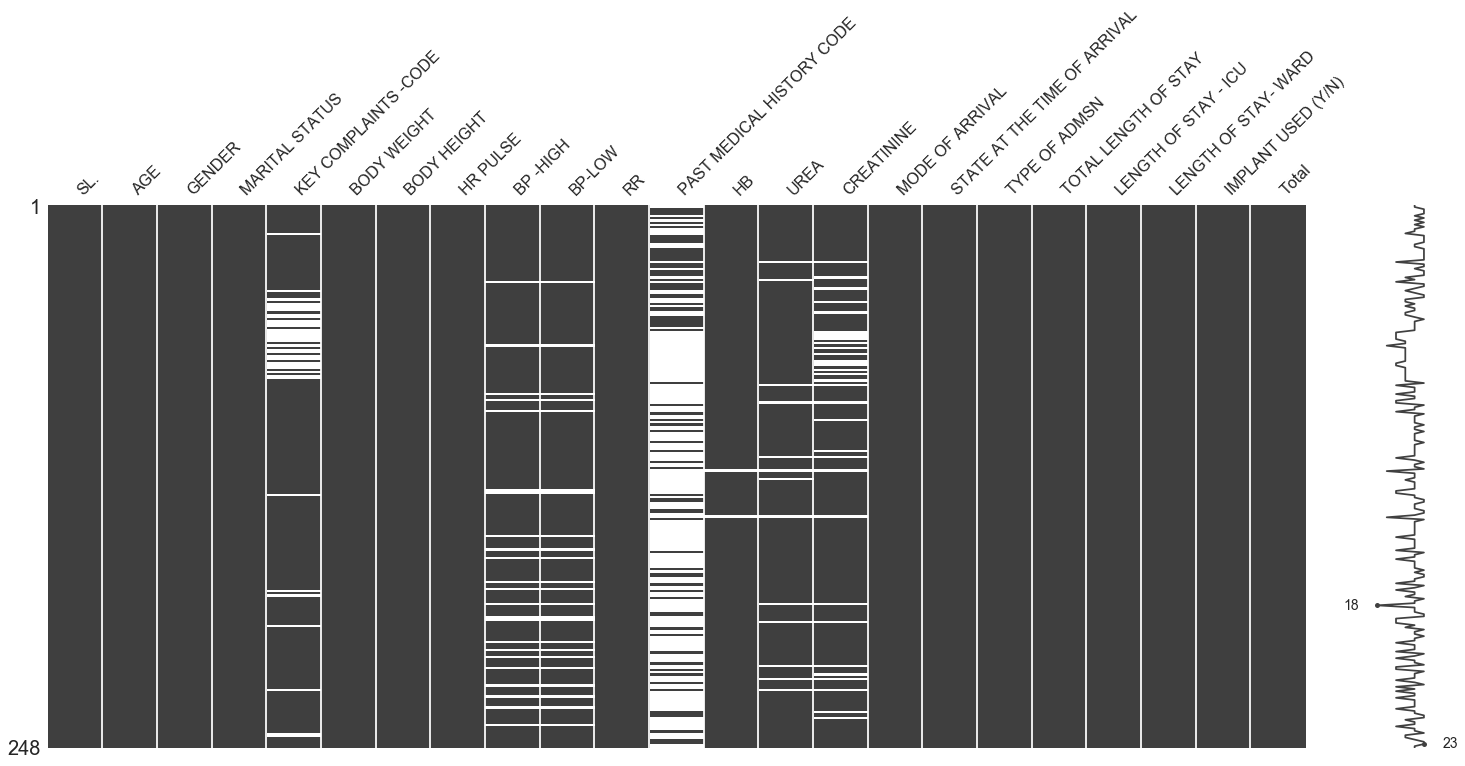

In [8]:
msno.matrix(df)

#### Droping 'PAST MEDICAL HISTORY CODE' as most of the value is null.
#### Droping 'KEY COMPLAINTS -CODE', as VIF is greater than 20 and 36 data is null. To be considered later...

In [9]:
df.drop(['PAST MEDICAL HISTORY CODE', 'KEY COMPLAINTS -CODE'], axis= 1, inplace = True )

#### Reading statistical info...

In [10]:
df.describe()

,SL.,AGE,BODY WEIGHT,BODY HEIGHT,HR PULSE,BP -HIGH,BP-LOW,RR,HB,UREA,CREATININE,TOTAL LENGTH OF STAY,LENGTH OF STAY - ICU,LENGTH OF STAY- WARD,Total
count,248.000000,248.000000,248.000000,248.000000,248.000000,225.000000,225.000000,248.000000,246.000000,235.000000,215.000000,248.000000,248.000000,248.000000,248.000000
mean,124.500000,28.879837,37.524677,130.221774,92.229839,115.022222,71.875556,23.540323,12.894553,26.581702,0.746977,11.612903,3.475806,8.153226,207267.531895
std,71.735626,25.899359,23.118822,39.170901,20.308740,22.536368,15.313176,3.840756,3.083237,15.998367,0.548641,5.392617,3.853520,3.755793,134327.395588
min,1.000000,0.032877,2.020000,19.000000,41.000000,70.000000,39.000000,12.000000,5.000000,2.000000,0.100000,3.000000,0.000000,0.000000,46093.000000
25%,62.750000,6.000000,15.000000,105.000000,78.000000,100.000000,60.000000,22.000000,11.300000,18.000000,0.300000,8.000000,1.000000,6.000000,131652.750000
50%,124.500000,15.500000,40.900000,147.500000,90.000000,110.000000,70.000000,24.000000,12.350000,22.000000,0.700000,10.000000,2.000000,7.000000,163164.660000
75%,186.250000,55.000000,58.250000,160.000000,104.000000,130.000000,80.000000,24.000000,14.000000,30.000000,1.000000,13.000000,4.000000,10.000000,241065.050000
max,248.000000,88.000000,85.000000,185.000000,155.000000,215.000000,140.000000,42.000000,25.700000,143.000000,5.200000,41.000000,30.000000,22.000000,908464.000000


#### Creating dummies for categorical features

In [11]:
def create_dummies( df, colname ):
    col_dummies = pd.get_dummies(df[colname], prefix=colname)
    col_dummies.drop(col_dummies.columns[0], axis=1, inplace=True)
    df = pd.concat([df, col_dummies], axis=1)
    df.drop( colname, axis = 1, inplace = True )
    return df

In [12]:
df_c = df[categorical_features]
for c_feature in categorical_features:
  df_c = create_dummies( df_c, c_feature )

#### Pre-processing data for numerical features

In [13]:
df_n = df[numerical_features]

#Filling NaN with 0.0, as the only 33(maximum) data point is null.
df_n = df_n.fillna(0.0)

#df1 = df1.astype('float64')

#### Normalizing...

In [14]:
def normalize(df):
    # call MinMaxScaler object
    min_max_scaler = MinMaxScaler()
    # feed in a numpy array
    X_train_norm = min_max_scaler.fit_transform(df)
    # wrap it up if you need a dataframe
    df_normalized = pd.DataFrame(X_train_norm, columns=df_n.columns)
    return df_normalized

In [15]:
df_nn = normalize(df_n)

#### Tests on Nonlinearity

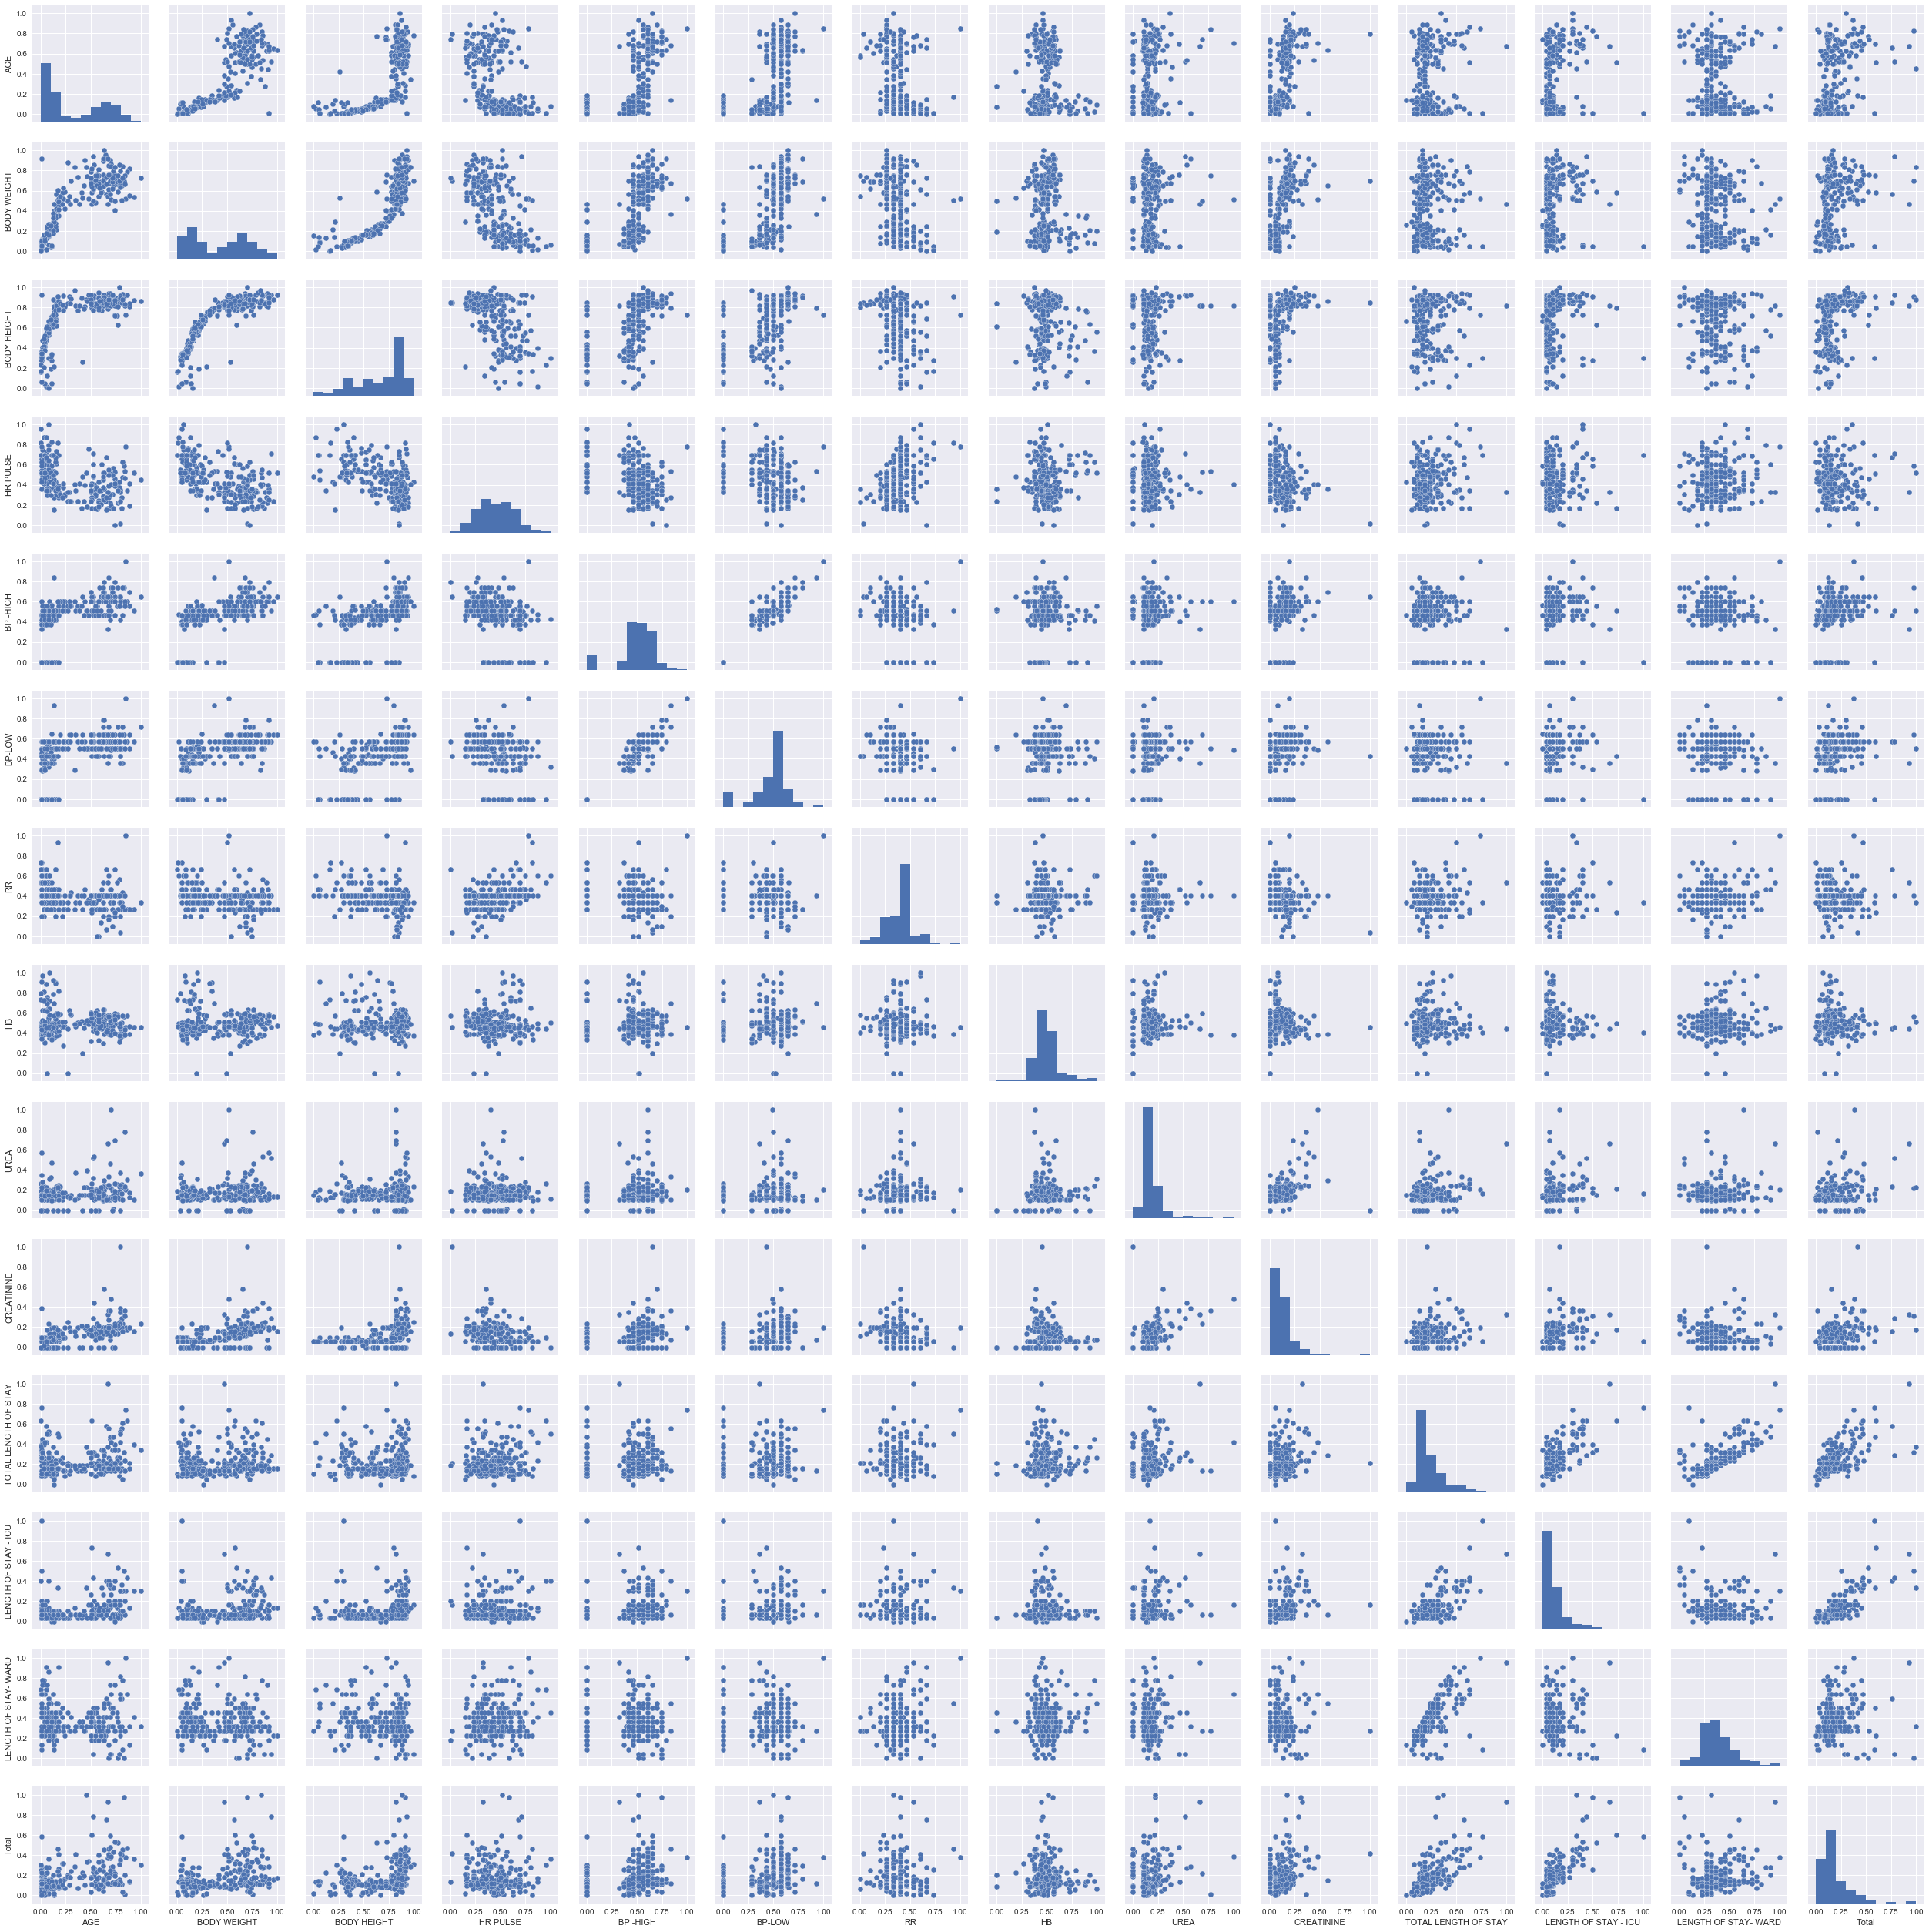

In [16]:
sn.pairplot(df_nn)

#### Joing two data frame...

In [17]:
df_total = pd.concat([df_nn, df_c], axis=1)
df_total.dropna(inplace=True)

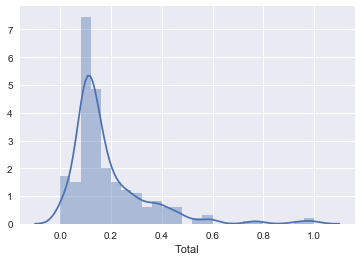

In [18]:
Y = df_total['Total']
sn.distplot(Y)

In [19]:
feature_columns = df_total.columns.difference( ['Total'] )
feature_columns

X = df_total[feature_columns]

#### Tests for Collinearity

In [20]:
X = X.drop(['TOTAL LENGTH OF STAY', 'BP -HIGH', 'MODE OF ARRIVAL_WALKED IN', 'BODY HEIGHT'
           , 'HB', 'BODY WEIGHT', 'RR', 'AGE', 'GENDER_M', 'TYPE OF ADMSN_EMERGENCY'], axis =1)

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif.round(1)

,VIF Factor,features
0,5.0,BP-LOW
1,6.4,CREATININE
2,8.8,HR PULSE
3,1.4,IMPLANT USED (Y/N)_Y
4,2.2,LENGTH OF STAY - ICU
5,5.2,LENGTH OF STAY- WARD
6,3.9,MARITAL STATUS_UNMARRIED
7,1.1,MODE OF ARRIVAL_TRANSFERRED
8,1.9,STATE AT THE TIME OF ARRIVAL_CONFUSED
9,5.4,UREA


#### Running the regression...

In [21]:
X = sm.add_constant(X)

model = sm.OLS(np.sqrt(Y),np.power(X,2)).fit() #As per tukeys rule of transformation. Box-cox can also be used.
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Total   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.675
Method:                 Least Squares   F-statistic:                     52.36
Date:                Sun, 07 Apr 2019   Prob (F-statistic):           2.01e-54
Time:                        11:38:49   Log-Likelihood:                 252.99
No. Observations:                 248   AIC:                            -484.0
Df Residuals:                     237   BIC:                            -445.3
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [22]:
influence = model.get_influence()
resid_student = influence.resid_studentized_external
(cooks, p) = influence.cooks_distance
(dffits, p) = influence.dffits
leverage = influence.hat_matrix_diag

/Users/anupsagar/anaconda/lib/python3.6/site-packages/statsmodels/stats/outliers_influence.py:323: RuntimeWarning: divide by zero encountered in true_divide
  return  self.results.resid / sigma / np.sqrt(1 - hii)
/Users/anupsagar/anaconda/lib/python3.6/site-packages/statsmodels/stats/outliers_influence.py:417: RuntimeWarning: divide by zero encountered in true_divide
  cooks_d2 *= hii / (1 - hii)
/Users/anupsagar/anaconda/lib/python3.6/site-packages/statsmodels/stats/outliers_influence.py:366: RuntimeWarning: divide by zero encountered in true_divide
  dffits_ = self.resid_studentized_external * np.sqrt(hii / (1 - hii))


In [23]:
df_total_res = pd.concat([pd.Series(cooks, name = "cooks"), pd.Series(dffits, name = "dffits"), pd.Series(leverage, name = "leverage"), pd.Series(resid_student, name = "resid_student")], axis = 1)
df_total_res = pd.concat([df_total, df_total_res], axis = 1)
df_total_res.head() 

,AGE,BODY WEIGHT,BODY HEIGHT,HR PULSE,BP -HIGH,BP-LOW,RR,HB,UREA,CREATININE,...,MARITAL STATUS_UNMARRIED,MODE OF ARRIVAL_TRANSFERRED,MODE OF ARRIVAL_WALKED IN,STATE AT THE TIME OF ARRIVAL_CONFUSED,TYPE OF ADMSN_EMERGENCY,IMPLANT USED (Y/N)_Y,cooks,dffits,leverage,resid_student
0,0.658963,0.568571,0.849398,0.675439,0.465116,0.571429,0.666667,0.443580,0.230769,0.153846,...,0,0,0,0,1,1,0.010128,0.334724,0.045423,1.534461
1,0.670331,0.469752,0.819277,0.324561,0.325581,0.357143,0.533333,0.443580,0.664336,0.326923,...,0,0,0,0,1,1,0.014733,-0.402165,0.238603,-0.718409
2,0.931793,0.537238,0.873494,0.517544,0.511628,0.571429,0.266667,0.459144,0.104895,0.153846,...,0,0,1,0,0,0,0.004076,0.212439,0.017489,1.592283
3,0.522549,0.939745,0.927711,0.710526,0.511628,0.571429,0.400000,0.459144,0.517483,0.288462,...,0,0,0,0,1,1,0.032138,0.598809,0.075500,2.095413
4,0.681699,0.674620,0.939759,0.271930,0.837209,0.714286,0.200000,0.389105,0.335664,0.365385,...,0,0,0,0,1,0,0.001487,0.127697,0.070794,0.462635


In [24]:
r = df_total_res.resid_student
df_total_res[abs(r) > 2]

,AGE,BODY WEIGHT,BODY HEIGHT,HR PULSE,BP -HIGH,BP-LOW,RR,HB,UREA,CREATININE,...,MARITAL STATUS_UNMARRIED,MODE OF ARRIVAL_TRANSFERRED,MODE OF ARRIVAL_WALKED IN,STATE AT THE TIME OF ARRIVAL_CONFUSED,TYPE OF ADMSN_EMERGENCY,IMPLANT USED (Y/N)_Y,cooks,dffits,leverage,resid_student
3,0.522549,0.939745,0.927711,0.710526,0.511628,0.571429,0.400000,0.459144,0.517483,0.288462,...,0,0,0,0,1,1,0.032138,0.598809,0.075500,2.095413
6,0.829482,0.698723,0.909639,0.587719,0.744186,0.642857,0.400000,0.564202,0.216783,0.307692,...,0,0,1,0,0,0,0.105630,1.113668,0.068084,4.120216
11,0.511181,0.578212,0.795181,0.166667,0.511628,0.428571,0.233333,0.494163,0.209790,0.173077,...,0,0,1,0,0,1,0.080003,-0.944566,0.172516,-2.068701
12,0.454342,0.836105,0.879518,0.517544,0.511628,0.500000,0.333333,0.513619,0.223776,0.173077,...,0,0,1,0,0,1,0.049364,0.764738,0.029478,4.387963
14,0.772642,0.590263,0.626506,0.219298,0.558140,0.571429,0.266667,0.486381,0.146853,0.134615,...,1,0,0,0,1,0,0.041235,0.680147,0.074931,2.389784
16,0.738539,0.758978,0.728916,0.456140,0.651163,0.571429,0.200000,0.486381,0.104895,0.192308,...,0,0,0,0,1,0,0.012900,0.380697,0.023328,2.463289
34,0.795378,0.698723,0.849398,0.017544,0.651163,0.428571,0.033333,0.455253,0.000000,1.000000,...,0,0,0,1,1,1,inf,inf,1.000000,inf
35,0.009099,0.047963,0.295181,0.692982,0.000000,0.000000,0.333333,0.404669,0.167832,0.057692,...,1,0,1,0,0,0,3.419113,-6.550623,0.555038,-5.865193
51,0.636228,0.650518,0.861446,0.359649,0.697674,0.571429,0.400000,0.389105,0.293706,0.576923,...,0,1,0,0,0,0,0.770865,-2.949798,0.547235,-2.683128
154,0.010994,0.081706,0.355422,0.517544,0.390698,0.492857,0.600000,0.490272,0.132867,0.057692,...,1,0,1,0,0,0,0.003785,-0.205633,0.008939,-2.165258


In [25]:
leverage = df_total_res.leverage
df_total_res[abs(leverage) > ((2*10)+2)/248]

,AGE,BODY WEIGHT,BODY HEIGHT,HR PULSE,BP -HIGH,BP-LOW,RR,HB,UREA,CREATININE,...,MARITAL STATUS_UNMARRIED,MODE OF ARRIVAL_TRANSFERRED,MODE OF ARRIVAL_WALKED IN,STATE AT THE TIME OF ARRIVAL_CONFUSED,TYPE OF ADMSN_EMERGENCY,IMPLANT USED (Y/N)_Y,cooks,dffits,leverage,resid_student
1,0.670331,0.469752,0.819277,0.324561,0.325581,0.357143,0.533333,0.443580,0.664336,0.326923,...,0,0,0,0,1,1,0.014733,-0.402165,0.238603,-0.718409
5,0.852218,0.517956,0.728916,0.780702,1.000000,1.000000,1.000000,0.459144,0.202797,0.192308,...,0,0,0,0,1,0,0.111311,-1.111131,0.293401,-1.724333
11,0.511181,0.578212,0.795181,0.166667,0.511628,0.428571,0.233333,0.494163,0.209790,0.173077,...,0,0,1,0,0,1,0.080003,-0.944566,0.172516,-2.068701
27,0.533917,0.856592,0.915663,0.403509,0.465116,0.500000,0.333333,0.568093,0.531469,0.442308,...,0,0,0,0,1,0,0.000108,-0.034374,0.109224,-0.098164
33,0.079201,0.060014,0.295181,1.000000,0.423256,0.321429,0.600000,0.505837,0.111888,0.000000,...,1,0,1,0,0,0,0.012480,0.370778,0.093361,1.155443
34,0.795378,0.698723,0.849398,0.017544,0.651163,0.428571,0.033333,0.455253,0.000000,1.000000,...,0,0,0,1,1,1,inf,inf,1.000000,inf
35,0.009099,0.047963,0.295181,0.692982,0.000000,0.000000,0.333333,0.404669,0.167832,0.057692,...,1,0,1,0,0,0,3.419113,-6.550623,0.555038,-5.865193
42,0.761274,0.686671,0.716867,0.412281,0.744186,0.500000,0.533333,0.389105,0.258741,0.192308,...,0,1,0,0,0,0,0.145572,1.273097,0.294407,1.970903
51,0.636228,0.650518,0.861446,0.359649,0.697674,0.571429,0.400000,0.389105,0.293706,0.576923,...,0,1,0,0,0,0,0.770865,-2.949798,0.547235,-2.683128
83,0.704435,0.514341,0.819277,0.403509,0.604651,0.485714,0.400000,0.381323,1.000000,0.480769,...,0,0,0,0,1,1,0.013121,0.379239,0.468655,0.403808


In [26]:
df_total_res[abs(df_total_res.dffits) > 2 * math.sqrt(3.0 / 51)]

,AGE,BODY WEIGHT,BODY HEIGHT,HR PULSE,BP -HIGH,BP-LOW,RR,HB,UREA,CREATININE,...,MARITAL STATUS_UNMARRIED,MODE OF ARRIVAL_TRANSFERRED,MODE OF ARRIVAL_WALKED IN,STATE AT THE TIME OF ARRIVAL_CONFUSED,TYPE OF ADMSN_EMERGENCY,IMPLANT USED (Y/N)_Y,cooks,dffits,leverage,resid_student
3,0.522549,0.939745,0.927711,0.710526,0.511628,0.571429,0.400000,0.459144,0.517483,0.288462,...,0,0,0,0,1,1,0.032138,0.598809,0.075500,2.095413
5,0.852218,0.517956,0.728916,0.780702,1.000000,1.000000,1.000000,0.459144,0.202797,0.192308,...,0,0,0,0,1,0,0.111311,-1.111131,0.293401,-1.724333
6,0.829482,0.698723,0.909639,0.587719,0.744186,0.642857,0.400000,0.564202,0.216783,0.307692,...,0,0,1,0,0,0,0.105630,1.113668,0.068084,4.120216
11,0.511181,0.578212,0.795181,0.166667,0.511628,0.428571,0.233333,0.494163,0.209790,0.173077,...,0,0,1,0,0,1,0.080003,-0.944566,0.172516,-2.068701
12,0.454342,0.836105,0.879518,0.517544,0.511628,0.500000,0.333333,0.513619,0.223776,0.173077,...,0,0,1,0,0,1,0.049364,0.764738,0.029478,4.387963
14,0.772642,0.590263,0.626506,0.219298,0.558140,0.571429,0.266667,0.486381,0.146853,0.134615,...,1,0,0,0,1,0,0.041235,0.680147,0.074931,2.389784
34,0.795378,0.698723,0.849398,0.017544,0.651163,0.428571,0.033333,0.455253,0.000000,1.000000,...,0,0,0,1,1,1,inf,inf,1.000000,inf
35,0.009099,0.047963,0.295181,0.692982,0.000000,0.000000,0.333333,0.404669,0.167832,0.057692,...,1,0,1,0,0,0,3.419113,-6.550623,0.555038,-5.865193
42,0.761274,0.686671,0.716867,0.412281,0.744186,0.500000,0.533333,0.389105,0.258741,0.192308,...,0,1,0,0,0,0,0.145572,1.273097,0.294407,1.970903
51,0.636228,0.650518,0.861446,0.359649,0.697674,0.571429,0.400000,0.389105,0.293706,0.576923,...,0,1,0,0,0,0,0.770865,-2.949798,0.547235,-2.683128


### Analyzing residuals...

#### Tests for Normality of Residuals

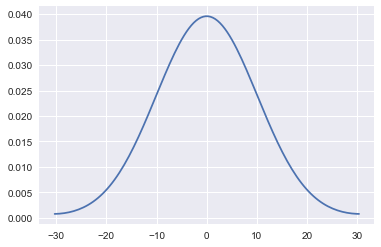

In [27]:
sn.kdeplot(np.array(model.resid), bw=10)

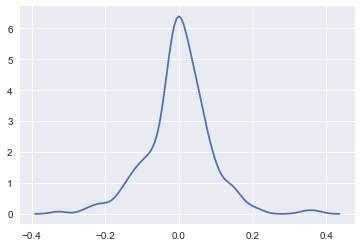

In [28]:
sn.distplot(np.array(model.resid), hist=False)

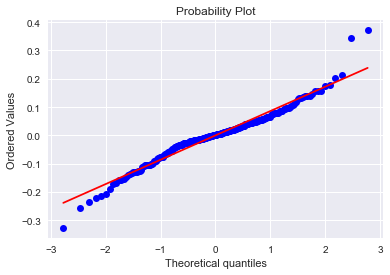

In [29]:
stats.probplot(model.resid, dist="norm", plot=pylab )
pylab.show();

In [30]:
print(normal_ad(model.resid))

(2.7467049423395054, 6.1968879926675905e-07)


#### The residuals have an approximately normal distribution.

#### Tests for Heteroscedasticity

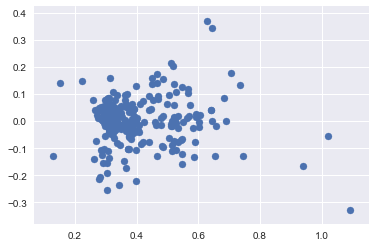

In [31]:
plt.scatter(model.predict(), model.resid )